In [8]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
# from sklearn.externals import joblib
import joblib
from sklearn.metrics import confusion_matrix
import time

window_size = 40 # 200Hz data -> 1.28 seconds per window
n_training = 30  # number of trials used for training, the rest for validation
n_components = 40 # PCA components
imu_dimensions = 6 # number of dimensions in imu data

classes = ['still', 'wave']


In [9]:
## compute fft features (amplitude of frequencies)
def computeIMUFeatures(df):
    # grab center 'window_size' data points    
    start = int((df.shape[0] - window_size)/2)
    d = df[start:start+window_size, 0:imu_dimensions]
    fft = np.abs(np.fft.fft(d, axis=0))
    fft = fft.reshape(-1)
    return fft

training activities: 0 testing activities: 0


IndexError: list index out of range

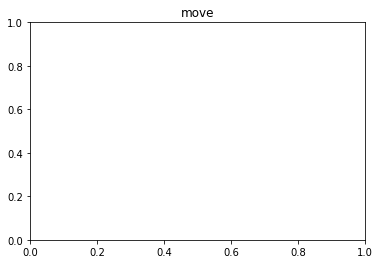

In [7]:
## load in the activities trial and put in training and testing set
trainingActivities = []
testingActivities = []
for idx, cls in enumerate(classes): 
    fileIndex = 1
    while True:
        path = './data1n2/' + cls + '/imu' + str(fileIndex) + '.txt'
        if not os.path.exists(path):
            break
        
        isTrainingData = fileIndex <= n_training
        raw_x = np.loadtxt(path, dtype=np.float32, delimiter=',')        
        x = computeIMUFeatures(raw_x)
        #print (cls, raw_x.shape, x.shape)
        
        if isTrainingData:
            trainingActivities.append((x, idx))
        else:
            testingActivities.append((x, idx))

        fileIndex += 1
print ('training activities:', len(trainingActivities), 'testing activities:', len(testingActivities))

## plot the first instance of each activity type to visualize the fft features
for i in range( len(classes)):
    pyplot.figure(i)
    pyplot.title(classes[i])
    pyplot.plot(trainingActivities[i * n_training][0])

In [ ]:
## apply PCA to reduce X dimentions
allTrainingX = np.empty(shape=(0, window_size * imu_dimensions))
allTestingX = np.empty(shape=(0, window_size * imu_dimensions))
for (x, y) in trainingActivities:
    allTrainingX = np.append(allTrainingX, np.expand_dims(x, axis=0), axis=0)
for (x, y) in testingActivities:
    allTestingX = np.append(allTestingX, np.expand_dims(x, axis=0), axis=0)
    
pca = PCA(n_components=n_components).fit(allTrainingX)
pyplot.plot(pca.explained_variance_ratio_.cumsum()) ## show explained variance

trainingX = pca.transform(allTrainingX)
testingX = pca.transform(allTestingX)

In [ ]:
def buildData(pca, activities):
    trainingX = np.empty(shape=(0, n_components))
    trainingY = np.empty(shape=(0, n_components))
    for (x, y) in activities:
        reducedX = pca.transform(np.expand_dims(x, axis=0))
        trainingX = np.append(trainingX, reducedX, axis=0)
        trainingY = np.append(trainingY, y)        
    return (trainingX, trainingY)

(trainingX, trainingY) = buildData(pca, trainingActivities)
(testingX, testingY) = buildData(pca, testingActivities)

#print (trainingX, trainingY)
#print (testingX, testingY)

for i in range(len(classes)):
    pyplot.figure(i)
    pyplot.title(classes[i])
    pyplot.plot(trainingX[i * n_training])

In [ ]:
for i in range(len(classes)):
    pyplot.figure(i)
    pyplot.plot(testingX[i])

In [ ]:
clf = SVC(kernel='linear')
clf.fit(trainingX, trainingY) 

print (clf.score(trainingX, trainingY) )

In [ ]:
print (clf.predict(testingX))
print (testingY)
print (np.sum(clf.predict(testingX) == testingY), testingY.shape[0])

print (confusion_matrix(testingY, clf.predict(testingX)))

In [ ]:
joblib.dump(clf, 'models/classifier.pkl') 
joblib.dump(pca, 'models/pca.pkl')

In [ ]:
pca2 = joblib.load('models/pca.pkl') 
clf2 = joblib.load('models/classifier.pkl') 

In [ ]:
startTime = time.time()
(testingX, testingY) = buildData(pca2, testingActivities)
print (clf2.predict(testingX))
endTime = time.time()
print ("take: " + str(endTime-startTime))